## 1. Ground truth model
Credits:

- Author: Gabin Rousseau
- Code source: predominantly https://github.com/Schumacher-group/cellcircuits

In [1]:
#Imports

#params
import numpy as np
from scipy.optimize import curve_fit

#analysis
from scipy.optimize import fsolve
from scipy.integrate import odeint

#main
import matplotlib.pyplot as plt

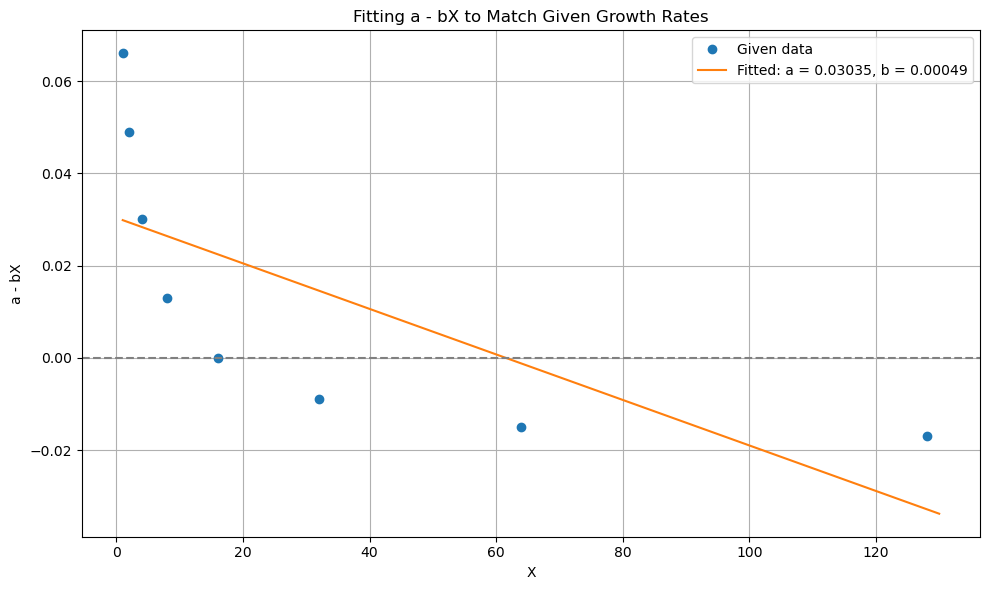

(np.float64(0.030346243271714948), np.float64(0.0004932154751910572))

In [ ]:
#ChatGPT 4o code for parameter fitting (goal: obtain same results as the S2H described dynamics)

# Define the inner function of the ODE: a - b*X
def inner_model(X, a, b): #curve_fit assumes ydata = f(xdata, *params) + eps
    return a - b * X

# Given data for a - b*X values at various X
X_data = np.array([1, 2, 4, 8, 16, 32, 64, 128])
inner_data = np.array([0.066, 0.049, 0.030, 0.013, 0.0, -0.009, -0.015, -0.017])

# Fit the inner model
params, _ = curve_fit(inner_model, X_data, inner_data) #function, x_data, y_data format
a_fit, b_fit = params

# Generate a smooth curve for visualization
X_fit = np.linspace(1, 130, 500)
inner_fit = inner_model(X_fit, a_fit, b_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit, inner_fit, '-', label=f'Fitted: a = {a_fit:.5f}, b = {b_fit:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Fitting a - bX to Match Given Growth Rates')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

a_fit, b_fit #the fit values


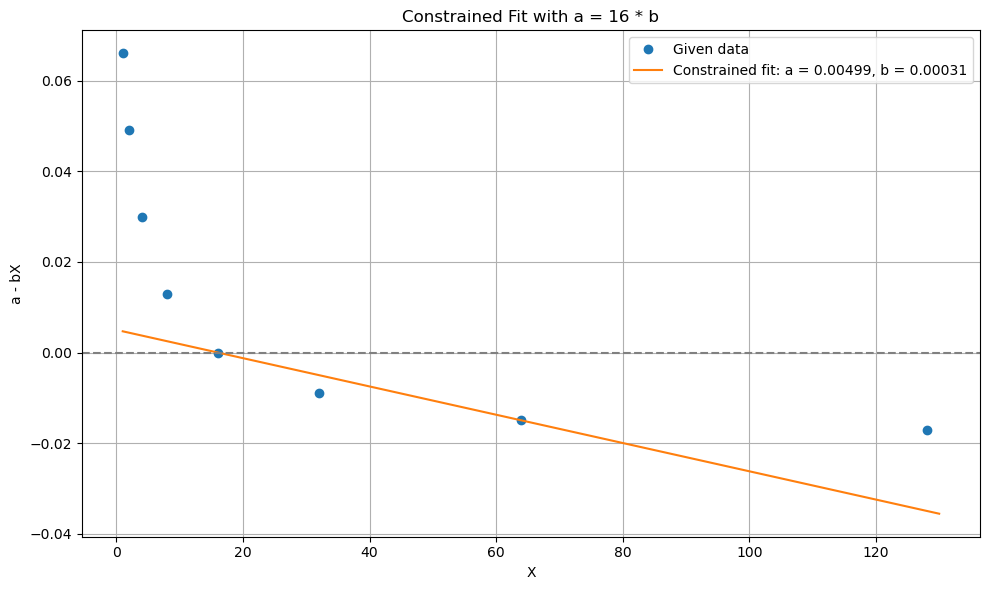

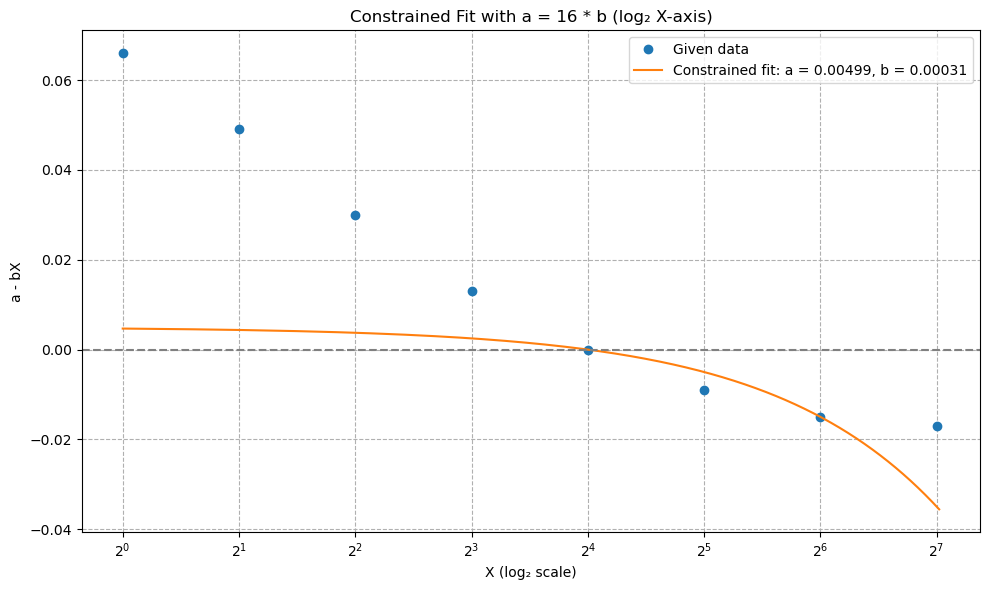

(np.float64(0.00499129218839478), np.float64(0.00031195576177467377))

In [ ]:
# constrained variant to ensure the steady state at X=16 (where a=16b)

# Redefine the model with the constraint a = 16 * b => a - bX = b(16 - X)
def constrained_model(X, b):
    return b * (16 - X)

# Fit the constrained model
from scipy.optimize import curve_fit
b_constrained, _ = curve_fit(constrained_model, X_data, inner_data)
a_constrained = 16 * b_constrained[0]

# Generate smooth curve for plotting
X_fit_constrained = np.linspace(1, 130, 500)
inner_fit_constrained = constrained_model(X_fit_constrained, b_constrained[0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('X')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the constrained fit over a log2-scaled x-axis
plt.figure(figsize=(10, 6))
plt.plot(X_data, inner_data, 'o', label='Given data')
plt.plot(X_fit_constrained, inner_fit_constrained, '-', label=f'Constrained fit: a = {a_constrained:.5f}, b = {b_constrained[0]:.5f}')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log', base=2)
plt.xlabel('X (log₂ scale)')
plt.ylabel('a - bX')
plt.title('Constrained Fit with a = 16 * b (log₂ X-axis)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

a_constrained, b_constrained[0] #it seems the ODE will struggle to capture the figure S2H results properly, but still, this gives us an initial direction.

In [ ]:
#Parameters
#Define Constants
lambda1 = 0.9  # proliferation rate of mF in 1/day
lambda2 = 0.8  #  proliferation rate of M in 1/day
mu1 = 0.3      #       removal rate of mF in 1/day
mu2 = 0.3      #        removal rate of M in 1/day
K = 10 ** 6    #  carrying capacity of mF in cells/ml
k1 = 10 ** 9   #  binding affinity of CSF in molecules/ml
k2 = 10 ** 9   # binding affinity of PDGF in molecules/ml


# converted from paper to match units min -> day
beta1  = 470 * 60 * 24 #    max secretion rate of CSF by mF in molecules/(cell * day) 
beta2  = 70 * 60 * 24  #    max secretion rate of PDGF by M in molecules/(cell * day)
beta3  = 240 * 60 * 24 #   max secretion rate of PDGF by mF in molecules/(cell * day)
alpha1 = 940 *60 * 24  #   max endocytosis rate of CSF by M in molecules/(cell * day)
alpha2 = 510 * 60 * 24 # max endocytosis rate of PDGF by mF in molecules/(cell * day)
gamma  = 2             # degradation rate of growth factors in 1/day
A_0 = 10**6            #             incoming injury signal in cells/day



F cells expected SS: 16.0
M cells expected SS: 16.0


In [ ]:
##### CELLCIRCUITS ANALYSIS #####

#Define ODE system

#Outputs list of gradients, state encompasses concentrations for mF, M, CSF and PDGF as cells per ml
def myofib_macro(state): # outputs list of gradients
    
    mF, M, CSF, PDGF = state

    d_mF_dt = mF * (lambda1 * (PDGF / (k1 + PDGF)) * (1 - mF / K) - mu1)
    d_M_dt = M * (lambda2 * (CSF / (k2+CSF)) - mu2)
    d_CSF_dt = beta1 * mF - alpha1 * M * (CSF / (k2 + CSF)) - gamma * CSF
    d_PDGF_dt = beta2 * M + beta3 * mF - alpha2 * mF * (PDGF / (k1 + PDGF))- gamma * PDGF

    return [d_mF_dt, d_M_dt, d_CSF_dt, d_PDGF_dt]

#find steady state for CSF and PDGF given mF and M levels using the fast timescale 
def CSF_PDGF_steady(x):
    mF = x[0]
    M = x[1]
    
    #In case the number of macrophages drops below 0 (e.g. in the numerical integration) interpret it as 0
    if M < 0:
        M = 0
    if mF < 0:
        mF = 0

    # equation for steady CSF is -gamma*(CSF)**2 + CSF*(beta1*mF-alpha1*M-k2*gamma) + beta1*k2*mF
    # equation for steady PDGF is  -gamma*(PDGF)**2 + PDGF * (beta2*M + beta3*mF -alpha2 * mF- gamma * k1) +k1*(beta2*M+beta3*mF)
    
    c_CSF = np.array([-1*gamma, beta1*mF-alpha1*M-k2*gamma, beta1*k2*mF])
    c_PDGF = np.array([-1*gamma, beta2*M + beta3*mF -alpha2 * mF - gamma * k1, k1*(beta2*M+beta3*mF)])
    CSF_roots = np.roots(c_CSF)
    PDGF_roots = np.roots(c_PDGF)
    root_pairs = []
    for CSF_root in CSF_roots:
        for PDGF_root in PDGF_roots:
                if np.isreal(CSF_root) and np.isreal(PDGF_root) and PDGF_root >= 0 and CSF_root >= 0:
                    root_pairs.append(CSF_root)
                    root_pairs.append(PDGF_root)
    return(root_pairs)

#t parameter is necessary for using the odeint function from scipy.integrate
def mF_M_rates(state, t):
    mF, M = state
    CSF, PDGF = CSF_PDGF_steady([mF, M])
    d_mF_dt = mF * (lambda1 * ((PDGF)/(k1+PDGF))*(1-mF/K)-mu1)
    d_M_dt = M*(lambda2*(CSF/(k2 + CSF))- mu2)
    return [d_mF_dt, d_M_dt]

def nullcline_mF(mF):
    smF_PDGF = (mu1 * k1 *K) / (lambda1 * K - mu1 *K - mF *lambda1)
    smF_M = -1 / beta2 * (beta3 * mF - alpha2 * mF * smF_PDGF / (k1 + smF_PDGF) - gamma * smF_PDGF)
    return [mF, smF_M]

def nullcline_M(sM_mF):
    sM_CSF = (k2 * mu2) / (lambda2 - mu2)
    M = ((k2 + sM_CSF) / (alpha1 * sM_CSF)) * (beta1 * sM_mF - gamma * sM_CSF)
    return [sM_mF, M]

def nulldiff(x):
    return nullcline_M(x)[1] - nullcline_mF(x)[1]

# finds intersection of nullclines, bad first estimate
def intersectionNull_bad(mFM_space):
    mF_list = []
    for i in range(len(mFM_space) - 1):
        if nulldiff(mFM_space[i]) * nulldiff(mFM_space[i + 1]) < 0 or nulldiff(mFM_space[i]) == 0:
            mF_list.append(mFM_space[i])
    return mF_list


def unstable_fixed_point_hotfibrosis_mF_M(mFM_space):
    #use intersection_Null_bad to make a first rough approximation of the fixed points
    fixed_point_mF_bad = intersectionNull_bad(mFM_space)
    fixed_point_M_bad = [nullcline_M(i)[1] for i in fixed_point_mF_bad]

    unstable_guess = fixed_point_mF_bad[0]
    hotfibrosis_guess = fixed_point_mF_bad[1]

    #Now use fsolve function to get a more precise solution and make it a floating number (instead of array)
    unstable_fixed_point_mF = fsolve(nulldiff, unstable_guess)[0]

    hotfibrosis_mF = fsolve(nulldiff, hotfibrosis_guess)[0]

    #find mF_M concentration at unstable fixed point
    unstable_fixed_point_mF_M = nullcline_mF(unstable_fixed_point_mF)

    #find mF_M concentrations at hotfibrosis point
    hotfibrosis_mF_M = nullcline_mF(hotfibrosis_mF)
    

    return (unstable_fixed_point_mF_M, hotfibrosis_mF_M)

def cold_fibr():
    # Set M = 0 in eqn 4, use eqn 1. solve system for PDGF, get a cubic

    PDGF_coeff = np.array([-gamma,
                           (K / lambda1) * (lambda1 - mu1) * (beta3 - alpha2) - gamma * k1,
                           (K * k1 / lambda1) * (beta3 * lambda1 - 2 * mu1 * beta3 + mu1 *alpha2),
                           -k1**2 * mu1 * K * beta3 / lambda1])
    # rearranged from eqns in transparent methods
    coldPDGF = np.roots(PDGF_coeff)
    coldmF = []
    
    for coldroot in coldPDGF:
        if np.isreal(coldroot) and coldroot >= 0:
            coldmF.append(K * ((lambda1 - mu1) / (lambda1) - (mu1 * k1) / (lambda1 * np.real(coldroot)))) # finds mF value given PDGF value
    
    return coldmF


#calculate separatrix
#outputs reverse derivative, state encompasses mF, M concentrations 
def myofib_macro_ODE_reverse(state, t):
    
    #checking if concentrations are in a reasonable range
    return [-d for d in mF_M_rates(state, t)] if all(0 <= x <= 10**7 for x in state) else [0, 0]

def calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix):
    eps = 1e-6
    separatrix_left = odeint(myofib_macro_ODE_reverse, [unstable_fixed_point_mF_M[0] - eps,
                                                        unstable_fixed_point_mF_M[1] + eps], t_separatrix)
    separatrix_right = odeint(myofib_macro_ODE_reverse, [unstable_fixed_point_mF_M[0] + eps,
                                                         unstable_fixed_point_mF_M[1] - eps], t_separatrix)
    return np.array(separatrix_left), np.array(separatrix_right)


#streamlines analysis

# finds steady CSF and PDGF levels for given mF and M levels numerically from the steady state equations
def CSF_PDGF_steady_array(x):
    mF = x[0]
    M = x[1]
    # equation for steady CSF is -gamma*(CSF)**2 + CSF*(beta1*mF-alpha1*M-k2*gamma) + beta1*k2*mF
    # equation for steady PDGF is  -gamma*(PDGF)**2 + PDGF * (beta2*M + beta3*mF -alpha2 * mF- gamma * k1) +k1*(beta2*M+beta3*mF)

    c_CSF_array = np.array([-1*gamma*np.ones(np.shape(mF)), beta1*mF-alpha1*M-k2*gamma, beta1*k2*mF])
    c_PDGF_array = np.array([-1*gamma*np.ones(np.shape(mF)), beta2*M + beta3*mF -alpha2 * mF - gamma * k1, k1*(beta2*M+beta3*mF)])
    # define empty arrays fo CSF and PDGF
    CSF_array = np.zeros(np.shape(mF)) #is an array of the form [[][]]
    PDGF_array = np.zeros(np.shape(mF))
    for i in range(0, np.shape(mF)[0]):
        for j in range(0, np.shape(mF)[1]):
            # get 1d arrays of CSF and PDGF coefficients for each grid value
            c_CSF = np.array([c_CSF_array[0][i][j], c_CSF_array[1][i][j], c_CSF_array[2][i][j]])
            c_PDGF = np.array([c_PDGF_array[0][i][j], c_PDGF_array[1][i][j], c_PDGF_array[2][i][j]])
            CSF_roots = np.roots(c_CSF)
            PDGF_roots = np.roots(c_PDGF)
            for CSF_root in CSF_roots:
                for PDGF_root in PDGF_roots:
                    if np.isreal(CSF_root) and np.isreal(PDGF_root) and PDGF_root >= 0 and CSF_root >= 0:
                        CSF_array[i][j] = CSF_root
                        PDGF_array[i][j] = PDGF_root
    return [CSF_array, PDGF_array] 

def mF_M_rates_array(exp_mF, exp_M):
    # we need dmFdt and dMdt to be plotted at different values as streamplot can only take in linearly spaced values,
    # so we take in the exponents of mF and M values to get logarithmically spaced
    mF = 10**exp_mF
    M = 10**exp_M
    CSF, PDGF = CSF_PDGF_steady_array([mF, M])
    d_mF_dt = mF * (lambda1 * ((PDGF)/(k1+PDGF))*(1-mF/K)-mu1)
    d_M_dt = M*(lambda2*(CSF/(k2 + CSF))- mu2)
    return d_mF_dt, d_M_dt






In [ ]:
###### PLOTTING CELLCIRCUITS #####
def plot_nullclines_fixed_points_separatrix(mFM_space, mFnull1, mFnull2, mFnull3, xsmooth, ysmooth, t_separatrix):
    plt.figure()
    plt.plot(nullcline_M(mFM_space)[0], nullcline_M(mFM_space)[1], 'r', label = 'Macrophage nullcline')

    plt.plot(nullcline_mF(mFnull1)[0], nullcline_mF(mFnull1)[1], 'b', label = 'Myofibroblast nullcline')
    plt.plot(nullcline_mF(mFnull2)[0], nullcline_mF(mFnull2)[1], 'b')
    plt.plot(nullcline_mF(mFnull3)[0], nullcline_mF(mFnull3)[1], 'b')
    plt.plot(xsmooth, ysmooth, 'b')


    plt.xlabel('Myofibroblasts')
    plt.ylabel('Macrophages')
    plt.xlim(1, 10**7)
    plt.ylim(1, 10**7)
    plt.xscale('log')
    plt.yscale('log')

    unstable_fixed_point_mF_M, hotfibrosis_mF_M = unstable_fixed_point_hotfibrosis_mF_M(mFM_space)

    coldfibrosis_mF_M = [cold_fibr()[0], 1]
    fixed_point_end_of_separatrix = [cold_fibr()[1], 1]

    plt.annotate('unstable fixed point', unstable_fixed_point_mF_M)
    plt.annotate('hot fibrosis fixed point', hotfibrosis_mF_M)
    plt.annotate('cold fibrosis fixed point', coldfibrosis_mF_M)

    plt.plot(unstable_fixed_point_mF_M[0], unstable_fixed_point_mF_M[1], marker = 'o', color = 'black')
    plt.plot(hotfibrosis_mF_M[0], hotfibrosis_mF_M[1], marker = 'o', color = 'black')
    plt.plot(coldfibrosis_mF_M[0], coldfibrosis_mF_M[1], marker = 'o', color = "black")
    plt.plot(fixed_point_end_of_separatrix[0], fixed_point_end_of_separatrix[1], marker = 'o', color = 'black')


    separatrix_left, separatrix_right = calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix)
    plt.plot(separatrix_left[:, 0], separatrix_left[:, 1], 'black', label = 'Separatrix')
    plt.plot(separatrix_right[:, 0],separatrix_right[:, 1], 'black')

    plt.legend()


def plot_streamlines(mFM_space, t_separatrix):
    fig = plt.figure()
    mF_mesh = np.linspace(0, 7, 30)
    M_mesh = np.linspace(0, 7, 30)
    mF_stream, M_stream = np.meshgrid(mF_mesh, M_mesh)

    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    mF_rate, M_rate = mF_M_rates_array(mF_stream, M_stream)

    #scale the rates to appropriate size
    mF_rate_scaled = mF_rate/(10**mF_stream)
    M_rate_scaled = M_rate/(10**M_stream)

    strm = ax.streamplot(mF_stream, M_stream, mF_rate_scaled, M_rate_scaled,
                     color = (np.sqrt((mF_rate_scaled)**2 + (M_rate_scaled)**2)) , cmap = 'autumn')

    unstable_fixed_point_mF_M, hotfibrosis_mF_M = unstable_fixed_point_hotfibrosis_mF_M(mFM_space)

    
    separatrix_left, separatrix_right = calculate_separatrix(unstable_fixed_point_mF_M, t_separatrix)
    

    coldfibrosis_mF_M = [cold_fibr()[0], 1]
    fixed_point_end_of_separatrix = [cold_fibr()[1], 1]

    ax.set_xlim(0, 7)
    ax.set_ylim(0,7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_xlabel('myofibroblasts')
    ax2.set_ylabel('macrophages')


    ax2.plot(separatrix_left[:, 0], separatrix_left[:, 1], 'black')
    ax2.plot(separatrix_right[:, 0], separatrix_right[:, 1], 'black')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1, 10**7)
    ax2.set_ylim(1, 10**7)
    ax2.plot(unstable_fixed_point_mF_M[0], unstable_fixed_point_mF_M[1], marker = 'o', color = 'black')
    ax2.plot(hotfibrosis_mF_M[0], hotfibrosis_mF_M[1], marker = 'o', color = 'black')
    ax2.plot(coldfibrosis_mF_M[0], coldfibrosis_mF_M[1], marker = 'o', color = "black")
    ax2.plot(fixed_point_end_of_separatrix[0], fixed_point_end_of_separatrix[1], marker = 'o', color = 'black')





In [ ]:
###### MAIN CELLCIRCUITS ######
def main_cc():
    #time vectors 
    t_trajectory = np.linspace(0, 100, 10001)
    t_separatrix = np.linspace(0, 800, 1000)

    #Initial mF and M concentration
    x_initial = [1,1]

    #Nullcline parameters for plotting
    mFM_space = np.logspace(0, 7, 10**4)

    #Between those intervalls the nullcline for mF has poles, so we smooth those out  
    mFnull1 = np.logspace(0, 5.7, 10**3)
    mFnull2 = np.logspace(5.85, 5.95, 10**3)
    mFnull3 = np.logspace(6.05, 7, 10**3)


    # straight lines to replace/ignore the sharp increase near the poles
    xsmooth = [10**5.7, 10**5.85]
    ysmooth = [nullcline_mF(pt)[1] for pt in xsmooth]

    plot_nullclines_fixed_points_separatrix(mFM_space, mFnull1, mFnull2, mFnull3, xsmooth, ysmooth, t_separatrix = t_separatrix)

    plot_streamlines(mFM_space, t_separatrix)
    #Depict the plots
    plt.show()



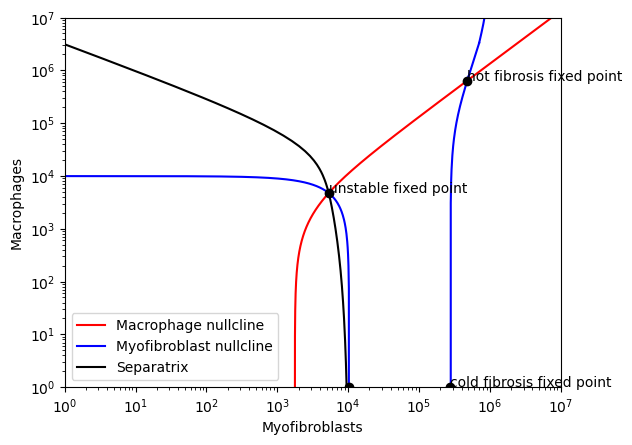

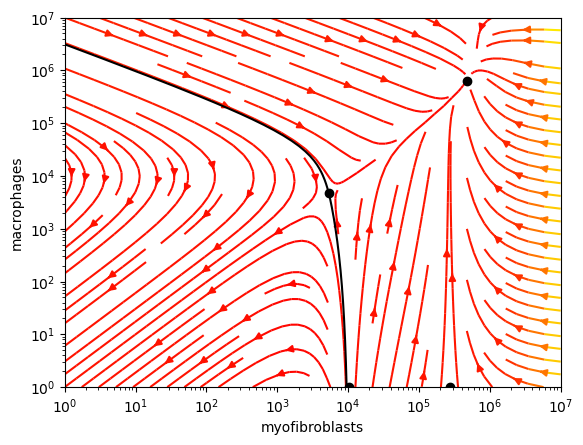

In [48]:
#Run main and plot phase portrait
main_cc()

F cells expected SS: 16.0
M cells expected SS: 16.0


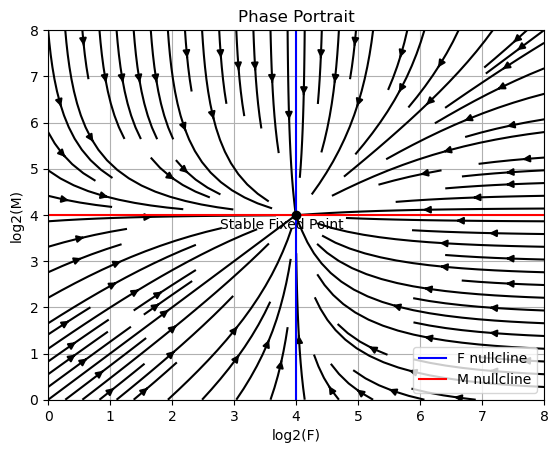

In [72]:
#######################################
##### OSDR known model parameters #####
#######################################

# After the description of the neighbourhood dynamics ODE in Methods, we have
# dX/dt = X(p^+(X) - p^-(X)), with constant division rate parameter p^+(X) = 0X + a, and death rate parameter p^-(X) = bX + 0.

# THUS: dX/dt = aX - bX^2, a logistic equation that fits simple autocatalysis models in molecular systems biology

# Steady state: X = 0 (unstable), X = a/b. So, if we want the steady state to be at 16 cells in the neighbourhood (4 on a log2 scale) of the same type (S2H)
# ... we want a = 16*b

# We expect this equation to have X decrease above its 16 SS, and increase below. This value is chosen to best correspond to the neighbourhood dynamics drawn in S2H.

F_a=48*10**-4
F_b=3*10**-4
print(f"F cells expected SS: {F_a/F_b}") #check for float-related errors (e.g. slightly incorrect result)

M_a=48*10**-4
M_b=3*10**-4
print(f"M cells expected SS: {M_a/M_b}")

# Define the system of ODEs
def ODE_system(state, t):
    F, M = state
    dF_dt = F * (F_a - F_b * F)
    dM_dt = M * (M_a - M_b * M)
    return [dF_dt, dM_dt]

# Calculate nullclines
def nullcline_F(F):
    return F_a / F_b

def nullcline_M(M):
    return M_a / M_b

# Generate streamlines
def streamlines(exp_F, exp_M):
    F = 2**exp_F
    M = 2**exp_M
    dF_dt, dM_dt = ODE_system([F, M], 0)
    return dF_dt, dM_dt

# Plot the phase portrait
def plot_phase_portrait():
    # Parameters for meshgrid
    exp_F_mesh = np.linspace(0, 8, 30)
    exp_M_mesh = np.linspace(0, 8, 30)
    exp_F, exp_M = np.meshgrid(exp_F_mesh, exp_M_mesh)

    # Calculate the growth rates for the streamlines
    F_rate, M_rate = streamlines(exp_F, exp_M)
    F_rate_scaled = F_rate / (2**exp_F)
    M_rate_scaled = M_rate / (2**exp_M)
    
    plt.figure()

    # Streamplot
    plt.streamplot(exp_F, exp_M, F_rate_scaled, M_rate_scaled,
                   color="black")

    # Nullclines
    plt.axvline(x=np.log2(F_a / F_b), color='b', linestyle='-', label='F nullcline')
    plt.axhline(y=np.log2(M_a / M_b), color='r', linestyle='-', label='M nullcline')
    

    # Fixed points
    fp_x = np.log2(F_a / F_b)
    fp_y = np.log2(M_a / M_b)
    plt.plot(fp_x, fp_y, 'ko')
    plt.annotate('Stable Fixed Point', (fp_x, fp_y), textcoords="offset points", xytext=(-10,-10), ha='center')

    # Labels and legend
    plt.xlabel('log2(F)')
    plt.ylabel('log2(M)')
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()

plot_phase_portrait()



F cells expected SS: 16.0
M cells expected SS: 16.0
[array([0., 0.]), array([16.,  0.]), array([ 0., 16.]), array([16., 16.])]
Unstable
Unstable
Unstable
Stable


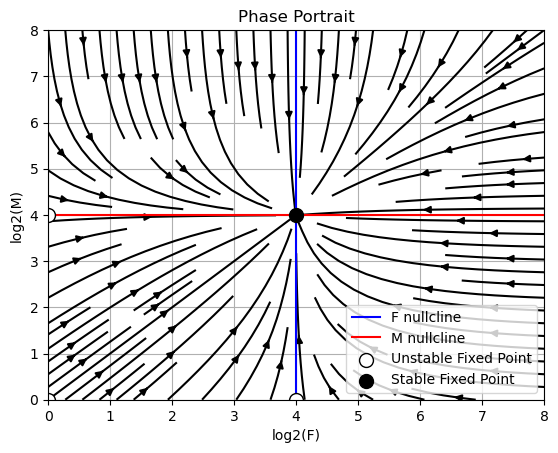

In [ ]:
import autograd.numpy as np
from autograd import jacobian

#######################################
##### OSDR known model parameters #####
#######################################

# After the description of the neighbourhood dynamics ODE in Methods, we have
# dX/dt = X(p^+(X) - p^-(X)), with constant division rate parameter p^+(X) = 0X + a, and death rate parameter p^-(X) = bX + 0.

# THUS: dX/dt = aX - bX^2, a logistic equation that fits simple autocatalysis models in molecular systems biology

# Steady state: X = 0 (unstable), X = a/b. So, if we want the steady state to be at 16 cells in the neighbourhood (4 on a log2 scale) of the same type (S2H)
# ... we want a = 16*b

# We expect this equation to have X decrease above its 16 SS, and increase below. This value is chosen to best correspond to the neighbourhood dynamics drawn in S2H.

#F parameters
F_a=48*10**-4
F_b=3*10**-4
print(f"F cells expected SS: {F_a/F_b}") #check for float-related errors (e.g. slightly incorrect result)

#M parameters
M_a=48*10**-4
M_b=3*10**-4
print(f"M cells expected SS: {M_a/M_b}")

# Define the system of ODEs
def ODE_system(state):
    F, M = state
    dF_dt = F * (F_a - F_b * F)
    dM_dt = M * (M_a - M_b * M)
    return [dF_dt, dM_dt]

def ODE_system_np(state):
    F, M = state
    dF_dt = F * (F_a - F_b * F)
    dM_dt = M * (M_a - M_b * M)
    return np.array([dF_dt, dM_dt])


# Generate rates for streamlines adapted to the log2 scale
def streamlines(exp_F, exp_M):
    F = 2**exp_F
    M = 2**exp_M
    dF_dt, dM_dt = ODE_system([F, M])
    return dF_dt, dM_dt


# Find nullclines using fsolve
def nullclines():
    F_range = np.logspace(0, 8, 400, base=2)
    M_range = np.logspace(0, 8, 400, base=2)

    F_nullcline = [fsolve(lambda F: ODE_system([F, M])[0], F_a/F_b) for M in M_range]
    M_nullcline = [fsolve(lambda M: ODE_system([F, M])[1], M_a/M_b) for F in F_range]
    
    return F_range, M_range, F_nullcline, M_nullcline

# Find fixed points using fsolve
def find_fixed_points():
    expected = [[0, 0], [F_a / F_b, 0], [0, M_a / M_b], [F_a / F_b, M_a / M_b]]
    fixed_points = [fsolve(ODE_system, expectation) for expectation in expected]
    return fixed_points

# Calculate stability using the Jacobian
def is_stable(fp):
    jac = jacobian(ODE_system_np)
    J = jac(fp)
    eigenvalues = np.linalg.eigvals(J)
    return all(e.real < 0 for e in eigenvalues)

# Plot the phase portrait
def plot_phase_portrait():
    # Parameters for meshgrid
    exp_F_mesh = np.linspace(0, 8, 30)
    exp_M_mesh = np.linspace(0, 8, 30)
    exp_F, exp_M = np.meshgrid(exp_F_mesh, exp_M_mesh)

    # Calculate the growth rates for the streamlines
    F_rate, M_rate = streamlines(exp_F, exp_M)
    F_rate_scaled = F_rate / (2**exp_F)
    M_rate_scaled = M_rate / (2**exp_M)
    
    plt.figure()

    # Streamplot
    plt.streamplot(exp_F, exp_M, F_rate_scaled, M_rate_scaled,
                   color="black")

    # Nullclines
    F_range, M_range, F_nullcline, M_nullcline = nullclines()
    plt.plot(np.log2(F_nullcline), np.log2(M_range), 'b-', label='F nullcline')
    plt.plot(np.log2(F_range), np.log2(M_nullcline), 'r-', label='M nullcline')
    

    # Fixed points
    fixed_points = find_fixed_points()
    print(fixed_points)
    # with stability analysis
    label_added = {'Stable': False, 'Unstable': False} #point label tracker to avoid redundancy
    for fp in fixed_points:
        x=(np.log2(fp[0])) if fp[0]!=0 else fp[0]
        y=(np.log2(fp[1])) if fp[1]!=0 else fp[1]
        stability = 'Stable' if is_stable(fp) else 'Unstable'
        print(stability)
        fcolor = 'black' if stability == 'Stable' else 'white'
        if label_added[stability]==False:
            plt.scatter(x, y, s=100, edgecolors="black", facecolors=fcolor, label=f'{stability} Fixed Point', zorder=2)
            label_added[stability]=True
        else:
            plt.scatter(x, y, s=100, edgecolors="black", facecolors=fcolor, zorder=2)

    # Labels and legend
    plt.xlabel('log2(F)')
    plt.ylabel('log2(M)')
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.title('Phase Portrait')
    plt.grid(True)
    plt.show()

plot_phase_portrait()



# 2. Simulation of cell distribution data biased by predefined model of division/death

In [2]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [ ]:
# parameters
cells=["F","M"] #cell type list

#n=100 #steps for stochastic proliferation

x_boundaries=(0,2500) #tissue size x boundaries in microns
y_boundaries=(0,2500) #tissue size y boundaries in microns

r=80 #neighbourhood radius in microns, same as in Somer et al.

#mF_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #division-death rate of mF based on #mF in neighbourhood
#M_rates=[0.066,0.049,0.030,0.013,0.00,-0.009,-0.015,-0.017] #same but with M for #M neibourhood

In [20]:
# 1. Sample a random initial number of cells for each type
mF_num=round(np.random.uniform(1, 10000))
print(f"Number of mF cells chosen: {mF_num}.")
M_num=round(np.random.uniform(1, 10000))
print(f"Number of M cells chosen: {M_num}.")

Number of mF cells chosen: 8712.
Number of M cells chosen: 5715.


In [4]:
# 2. Sample a random spatial position in the tissue for each cell.


def random_tissue(cells):
    cell_type=[]
    position_x=[]
    position_y=[]
    for cell in cells:
        cell_num=round(np.random.uniform(1, 10000))
        print(f"Number of {cell} cells chosen: {cell_num}.")
        for i in range(0, cell_num):
            cell_type.append(f"{cell}")
            position_x.append(np.random.uniform(x_boundaries[0],x_boundaries[1]))
            position_y.append(np.random.uniform(y_boundaries[0],y_boundaries[1]))
    tissue=pd.DataFrame(list(zip(cell_type,position_x,position_y)), columns=["Cell_Type","X","Y"])
    
    # Get all spatial coordinates as array for query
    coordinates = tissue[['X', 'Y']].values
    
    for cell in cells:
        # Build KD-Trees for each cell
        tree = cKDTree(tissue[tissue['Cell_Type'] == cell][['X', 'Y']].values)
        #Search neihbourhood contents of the current cell type for all cells
        neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == cell else 0)
               for coords, cat in zip(coordinates, tissue['Cell_Type'])]
        column_name=f"#{cell}_neighbours"
        tissue[column_name] = neighbours
        tissue[column_name+"_log2"] = np.log2(neighbours)
        print(np.isneginf(tissue[column_name+"_log2"]).any())
     
    return tissue

tissue=random_tissue(cells)
print(tissue.head())


Number of F cells chosen: 8335.
Number of M cells chosen: 6643.
False
False
  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         F  1193.382223  1638.222277             36            5.169925   
1         F   538.014178  2170.777617             28            4.807355   
2         F  2400.793927  1895.835309             14            3.807355   
3         F   506.978794   705.768679             33            5.044394   
4         F  2305.700793  1581.011351             22            4.459432   

   #M_neighbours  #M_neighbours_log2  
0             21            4.392317  
1             19            4.247928  
2             28            4.807355  
3             17            4.087463  
4             24            4.584963  


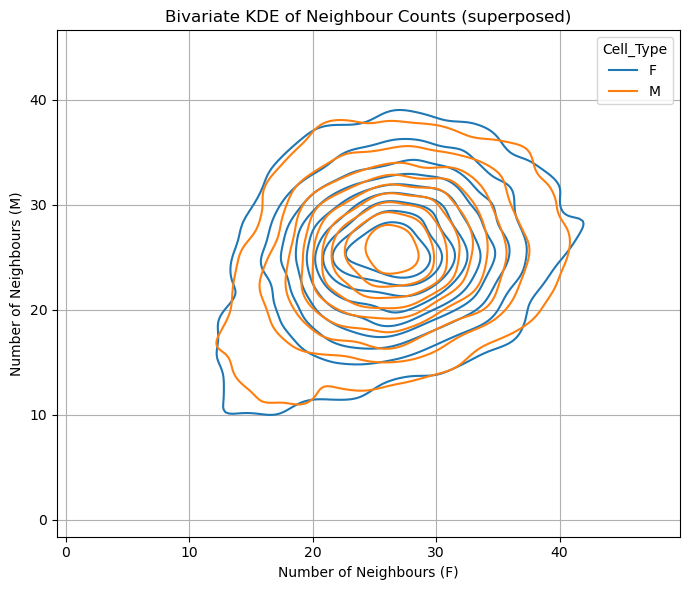

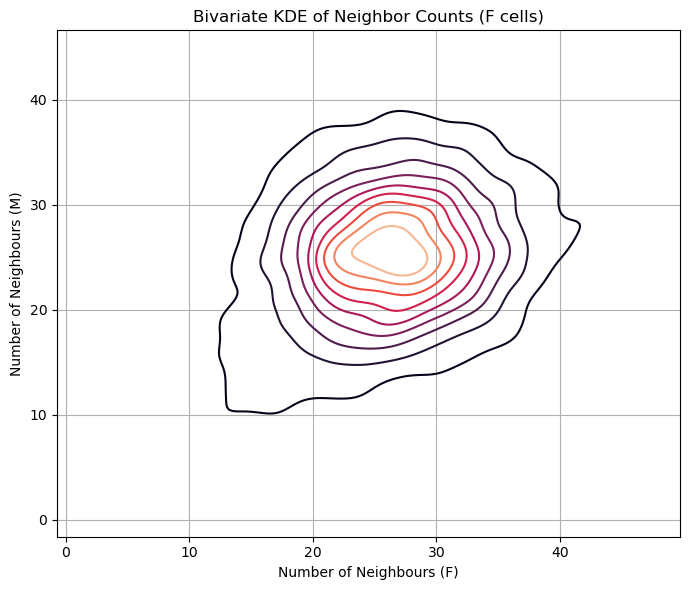

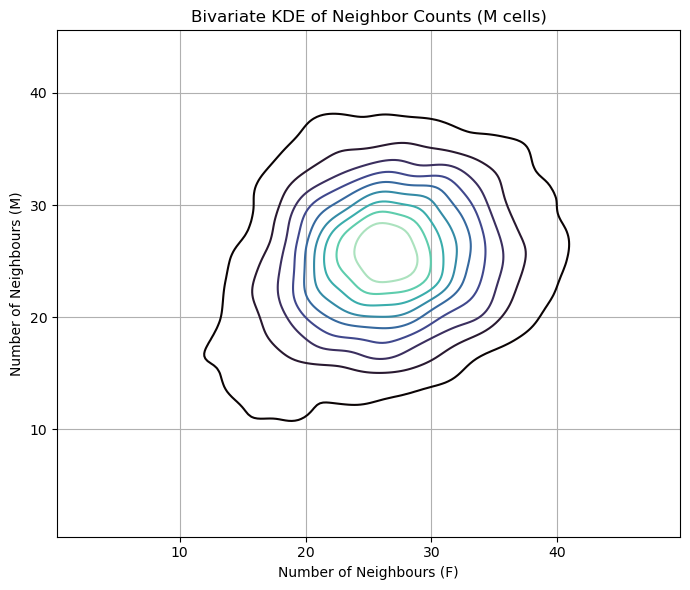

In [31]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = tissue[tissue['Cell_Type'] == 'F']
df_M = tissue[tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


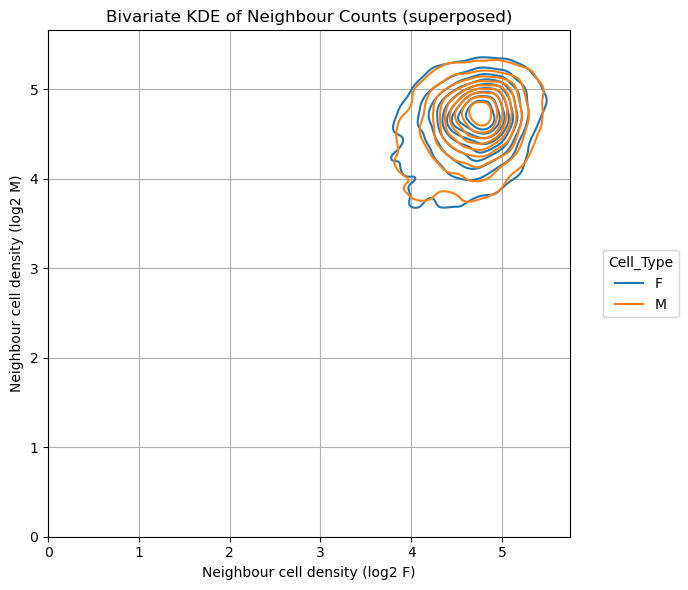

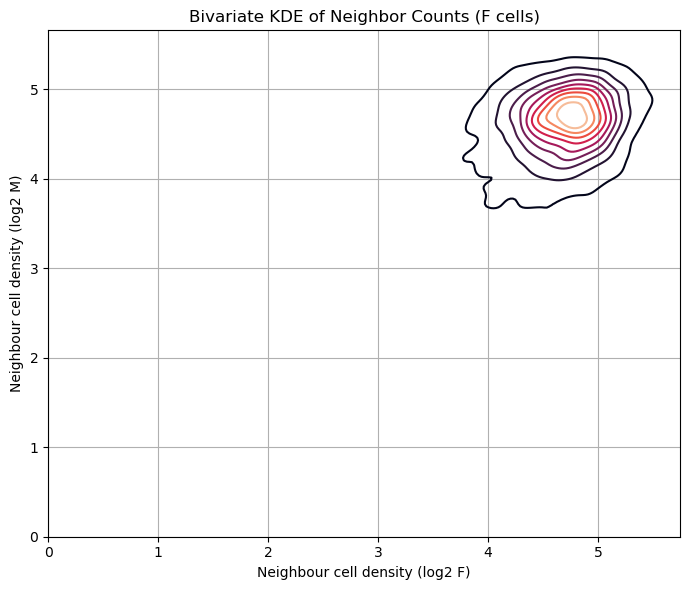

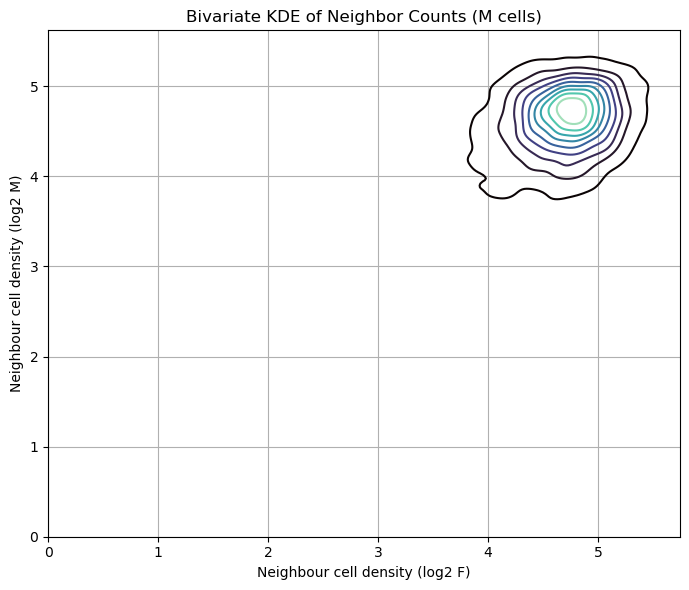

In [42]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=tissue[np.isfinite(tissue["#F_neighbours_log2"]) & np.isfinite(tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


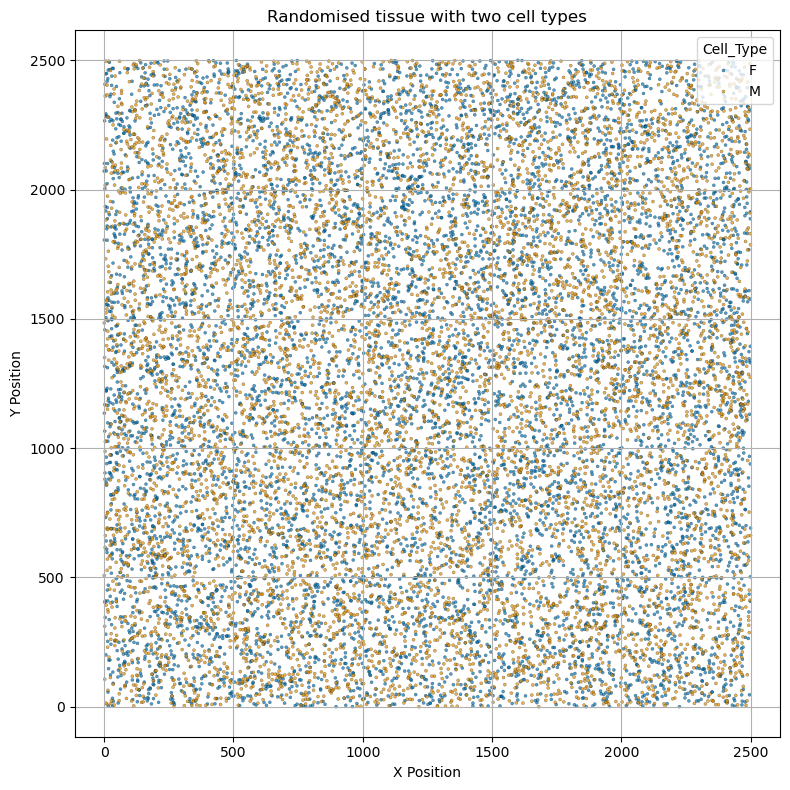

In [ ]:
#Show cells of the generated tissue
tissue_prolif=tissue.copy()
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm
#F parameters
F_a=48*10**-4
F_b=3*10**-4

#M parameters
M_a=48*10**-4
M_b=3*10**-4


# 3. stochastic biased proliferation over n steps

def tissue_proliferation(tissue, n=100, t=1): #time value, multiplies the rates
    for step in tqdm(range(0,n)):
        next_tissue=tissue.copy()
        dead_ids=[]
        for cell_id in range(0,len(tissue)):
            #get current cell
            cell=tissue.iloc[cell_id]

            #get event probabilities
            p_div=F_a*t if cell.iloc[0]=="F" else M_a*t
            p_death=F_b*cell.iloc[3]*t if cell.iloc[0]=="F" else M_b*cell.iloc[5]*t
            p_stay= 1 - p_div - p_death

            if p_stay < 0:
                print("Error with probability space")
                print(p_div)
                print(p_death)
                print(p_stay)
                print(p_div+p_death+p_stay)
                break

            #sample random event uniformly
            r1=np.random.uniform(0,1) #sample event for current cell

            #act on sampled event
            if r1 <= p_div: #division
                rx=np.random.uniform(-r,r)
                ry=np.random.uniform(-r,r)

                #prevent out of bounds and excessive proliferation on the edges
                if cell.iloc[1]+rx < 0 :
                    rx=np.random.uniform(0,r)
                elif cell.iloc[1]+rx > 2500 :
                    rx=np.random.uniform(-r,0)
                if cell.iloc[2]+ry < 0:
                    ry=np.random.uniform(0,r)
                elif cell.iloc[2]+ry > 2500:
                    ry=np.random.uniform(-r,0)
                
                new_cell=[cell.iloc[0],cell.iloc[1]+rx,cell.iloc[2]+ry,2,1,2,1]

                next_tissue.loc[len(next_tissue)]=new_cell
                
            elif r1 <=p_div+p_death: #death
                dead_ids.append(cell_id)
            elif r1<=p_div+p_death+p_stay: #nothing happens
                pass
            else: #if triggered, I made a mistake in the handling/definition of the events
                print("Unexpected random number.")
                break
        
        #remove chosen dead cells
        next_tissue=next_tissue.drop(dead_ids)
        next_tissue=next_tissue.reset_index(drop=True)

        #recompute neighbours
        coordinates = next_tissue[['X', 'Y']].values
        for type in cells:
            # Build KD-Trees for each cell type
            tree = cKDTree(next_tissue[next_tissue['Cell_Type'] == type][['X', 'Y']].values)
            #Search neihbourhood contents of the current cell type for all cells
            neighbours = [len(tree.query_ball_point(coords, r)) - (1 if cat == type else 0)
                for coords, cat in zip(coordinates, next_tissue['Cell_Type'])]
            column_name=f"#{type}_neighbours"
            next_tissue[column_name] = neighbours
            with np.errstate(divide='ignore', invalid='ignore'): #only log2 of 0 are expected to be compute, leading to -inf values. The log2 plots ignore these so just silence runtime warnings.
                next_tissue[column_name+"_log2"] = np.log2(neighbours)

        tissue=next_tissue.copy()
    return tissue

proliferated_tissue=tissue_proliferation(tissue, n=200, t=1)
print(proliferated_tissue.head())

100%|██████████| 200/200 [02:29<00:00,  1.34it/s]

  Cell_Type            X            Y  #F_neighbours  #F_neighbours_log2  \
0         F  1193.382223  1638.222277             24            4.584963   
1         F  2400.793927  1895.835309             18            4.169925   
2         F  1970.009388  1036.763355             15            3.906891   
3         F   675.020393  1247.790282             16            4.000000   
4         F  1076.859047   266.895859             20            4.321928   

   #M_neighbours  #M_neighbours_log2  
0             17            4.087463  
1             33            5.044394  
2             15            3.906891  
3             19            4.247928  
4             21            4.392317  


In [23]:
len(tissue)

14978

In [24]:
len(proliferated_tissue)

11940

In [10]:
np.random.uniform(-80,80)
dummy=tissue.copy()
dummy.loc[len(dummy)]=["F",12,13,16,4,16,4]
print(dummy.iloc[len(dummy)-1])

Cell_Type                F
X                     12.0
Y                     13.0
#F_neighbours           16
#F_neighbours_log2     4.0
#M_neighbours           16
#M_neighbours_log2     4.0
Name: 14978, dtype: object


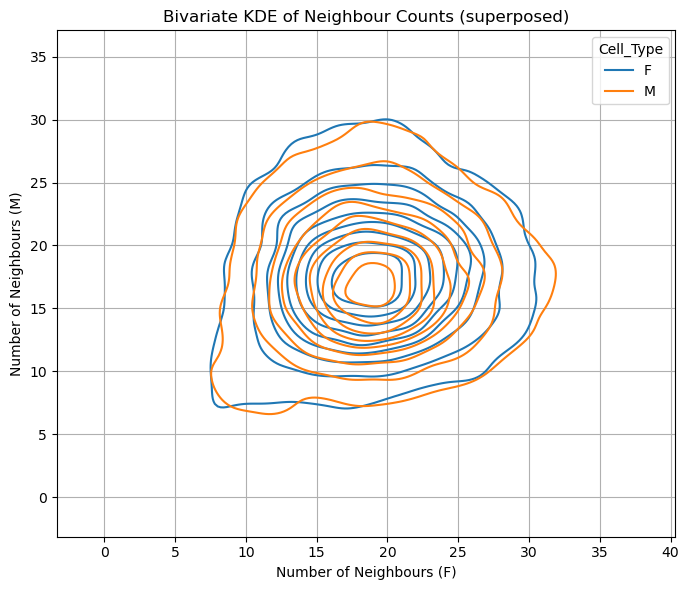

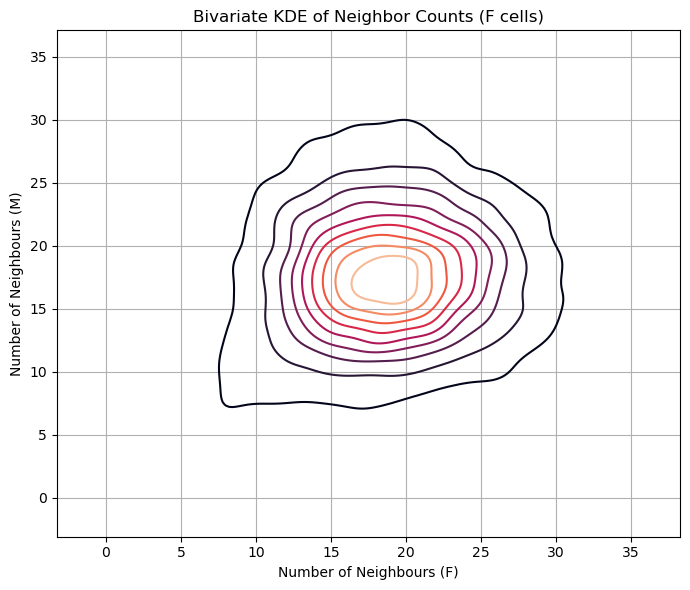

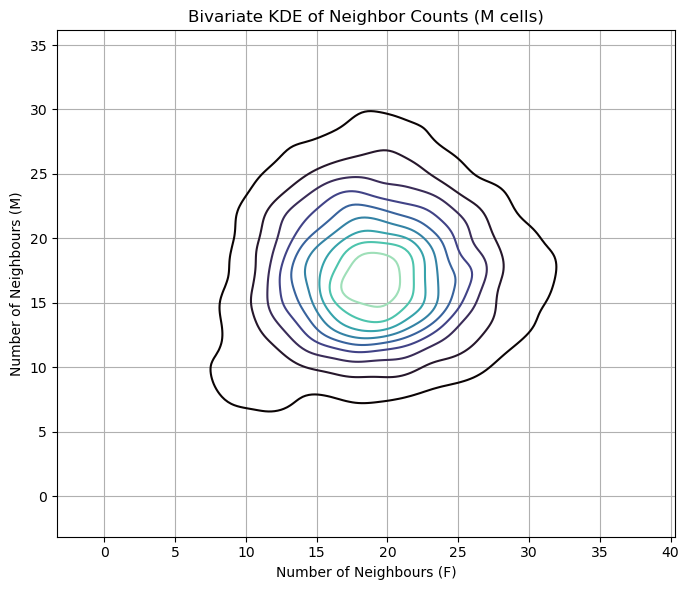

In [25]:
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=proliferated_tissue,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.xlabel('Number of Neighbours (F)')
plt.ylabel('Number of Neighbours (M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'F']
df_M = proliferated_tissue[proliferated_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours',
    y='#M_neighbours',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xlabel("Number of Neighbours (F)")
plt.ylabel("Number of Neighbours (M)")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4898/1211532032.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  log2_tissue=proliferated_tissue[np.isfinite(tissue["#F_neighbours_log2"]) & np.isfinite(tissue["#M_neighbours_log2"])]


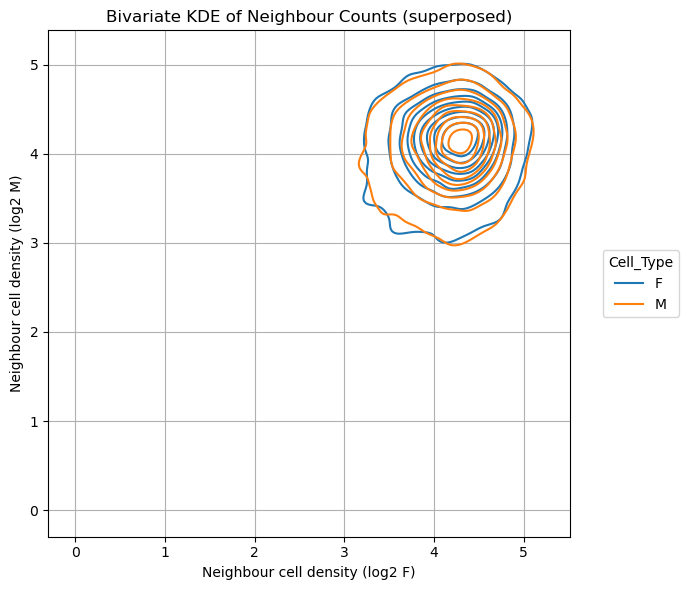

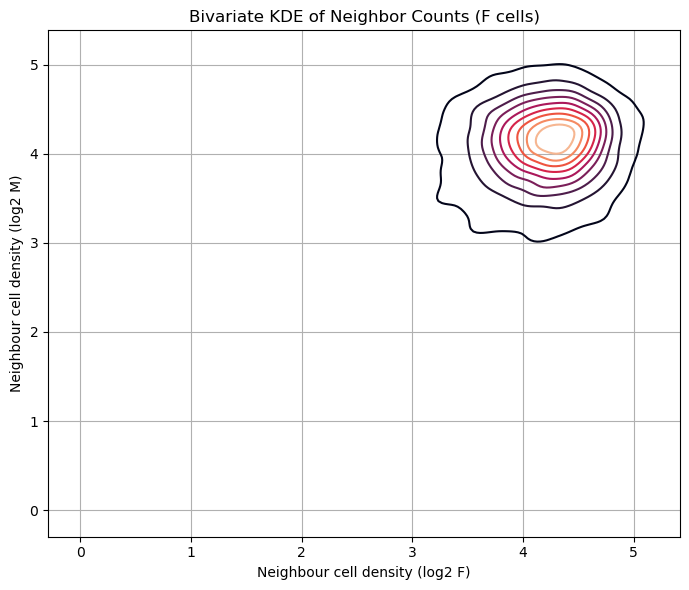

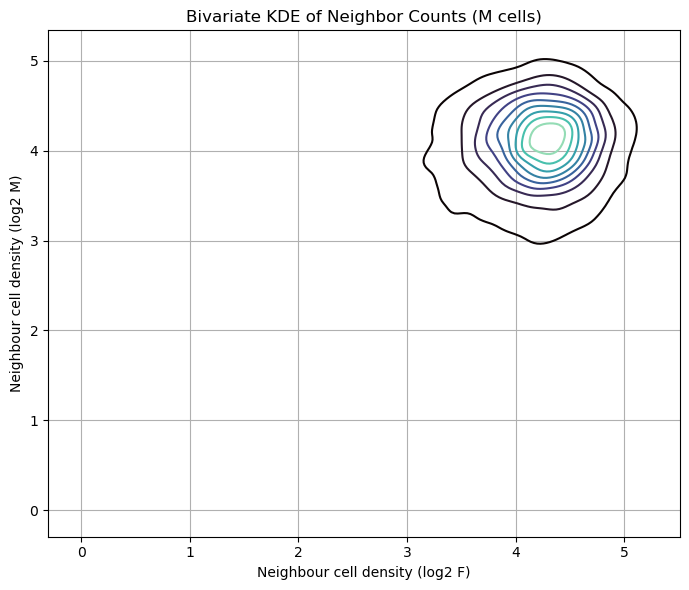

In [26]:
####LOG2 PLOTS####
#Superposed cel plots
#Plot generated tissue with bivariate KDE method
log2_tissue=proliferated_tissue[np.isfinite(tissue["#F_neighbours_log2"]) & np.isfinite(tissue["#M_neighbours_log2"])]
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=log2_tissue,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    #cmap='rocket',
    hue="Cell_Type",
    thresh=0.05,  
    levels=10,
)
plt.title('Bivariate KDE of Neighbour Counts (superposed)')
plt.gca().get_legend().set_bbox_to_anchor((1.05, 0.5))
plt.gca().get_legend().set_loc('center left')
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel('Neighbour cell density (log2 F)')
plt.ylabel('Neighbour cell density (log2 M)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Separate plots
# Isolate cell type dataframes
df_F = log2_tissue[log2_tissue['Cell_Type'] == 'F']
df_M = log2_tissue[log2_tissue['Cell_Type'] == 'M']

# 2) KDE plot for F cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_F,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='rocket',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (F cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) KDE plot for M cells
plt.figure(figsize=(7, 6))
sns.kdeplot(
    data=df_M,
    x='#F_neighbours_log2',
    y='#M_neighbours_log2',
    fill=False,
    cmap='mako',
    thresh=0.05,
    levels=10
)
plt.title("Bivariate KDE of Neighbor Counts (M cells)")
plt.xticks(np.arange(0, 6, 1))
plt.yticks(np.arange(0, 6, 1))
plt.xlabel("Neighbour cell density (log2 F)")
plt.ylabel("Neighbour cell density (log2 M)")
plt.grid(True)
plt.tight_layout()
plt.show()


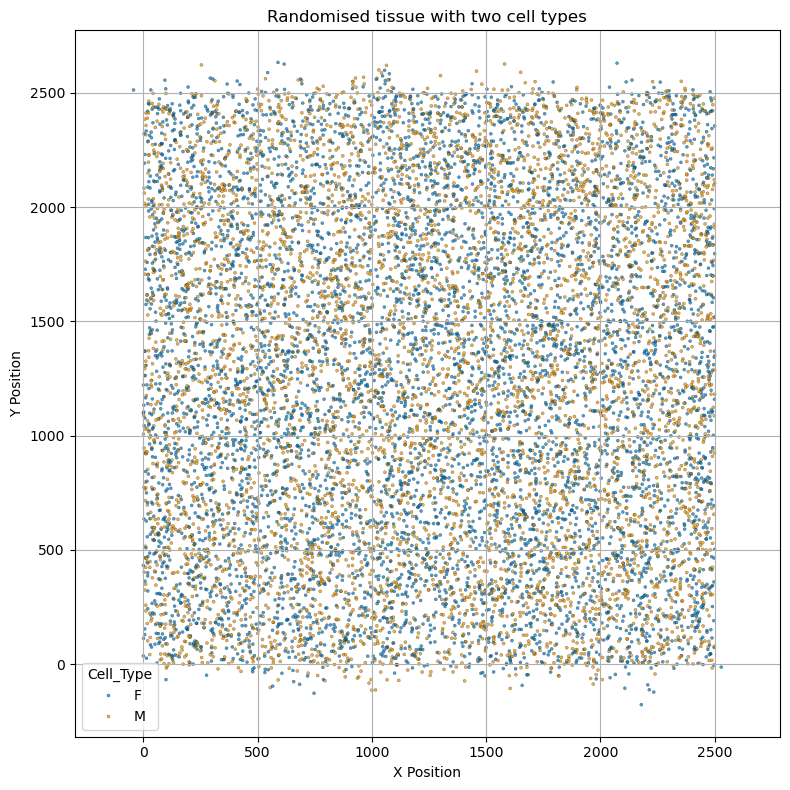

In [27]:
#Show cells of the generated tissue
tissue_prolif=tissue.copy()
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=proliferated_tissue,
    x='X',
    y='Y',
    hue='Cell_Type',
    palette='colorblind',   
    s=5,             
    edgecolor='black',
    alpha=0.7
)
plt.title("Randomised tissue with two cell types")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()